### SNN WP

In [31]:
!pip install snntorch
import snntorch as snn
import snntorch.functional as SF

from snntorch import spikeplot as splt

from snntorch import spikegen

import torch

import torch.nn as nn

import weight_perturbation as wp

In [32]:
# define a network


class SNN_WP(nn.Module):
    """
    SNN for weight perturbation. Consists of two fully connected layers of LIFs.
    """
    def __init__(self, beta, num_inputs, num_hidden, num_outputs, loss):
        """
        Initialize the network

        Parameters
        ----------
        beta : float
            The memory leakage of the LIF
        num_inputs : int
            The size of the input layer
        num_hidden : int
            The size of the output layer
        num_outputs : int
            The size of the output
        loss : Loss
            The loss used during training
        """
        super(SNN_WP, self).__init__()

        spike_grad = snn.surrogate.fast_sigmoid(slope=25) #needed for BP
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.loss = loss

    def clean_forward(self, x):
        """Wrapper function of forward for readability purposes"""
        return self.forward(x)

    def noisy_forward(self, x, noise):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains
        noise : dict
            Noise for each network parameter

        Returns
        -------
        spk : Array
            Output spike train
        """
        original_state = self.state_dict()
        perturbed_params = wp.dictionary_add(original_state, noise)
        self.load_state_dict(perturbed_params)
        spk = self.forward(x)

        # reset the parameters back to the unperturbed parameters
        self.load_state_dict(original_state)

        return spk

    def forward(self, x):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains

        Returns
        -------
        spk : Array
            Output spike train
        """
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()
        for step in range(x.shape[0]):
            cur1 = self.fc1(x[step])  # post-synaptic current <-- spk_in x weight
            spk1, self.mem1 = self.lif1(cur1, self.mem1)  # mem[t+1] <--post-syn current + decayed membrane
            cur2 = self.fc2(spk1)
            spk2, self.mem2 = self.lif2(cur2, self.mem2)
        return spk2

    def forward_pass(self, x, y, noise=None):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains
        y : Array
            True labels
        noise : dict, optional
            Noise for each network parameter

        Returns
        -------
        loss : long
            The loss of the pass
        """
        if noise is None:
            y_pred = self.clean_forward(x)
            return self.loss(y_pred, y)
        else:
            y_pred = self.noisy_forward(x, noise)
            return self.loss(y_pred, y)



In [95]:
class ClassificationDataset(torch.utils.data.Dataset):
    """Classification dataset."""

    def __init__(self, num_samples, timesteps, dim_in, num_classes, means, covariances):
        """Linear relation between input and output"""
        self.num_samples = num_samples * num_classes
        self.timesteps = timesteps
        self.dim_in = dim_in

        labels=[]
        data = []
        for ind, (mean, cov) in enumerate(zip(means, covariances)):
          z = torch.randn(num_samples, len(mean))  # Standard normal samples
          L = torch.linalg.cholesky(cov)  # Cholesky decomposition of covariance matrix
          cluster_data = z @ L.T + mean  # Transform to desired mean and covariance
          data.append(cluster_data)
          #print(torch.ones(num_samples)*ind)
          labels.append(torch.ones(num_samples)*ind)

        data = torch.cat(data, dim=0)
        labels = torch.cat(labels, dim=0)

        idxs = torch.randperm(self.num_samples)
        data = data[idxs, :]
        labels = labels[idxs]
        print(labels)
        data_normalized = (data - data.min()) / (data.max() - data.min() + 1e-6)
        self.features = snn.spikegen.rate(data_normalized, timesteps)
        self.labels = labels


    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        return self.features[:, idx, :], self.labels[idx]

In [97]:
means = [torch.tensor([2.0, 3.0]), torch.tensor([-3.0, -2.0])]  # List of mean vectors
covariances = [
    torch.tensor([[1.0, 0.5], [0.5, 1.0]]),  # Covariance matrix for cluster 1
    torch.tensor([[1.0, -0.9], [-0.9, 1.0]])  # Covariance matrix for cluster 2
]
num_samples_per_cluster = 50  # Samples per cluster

dataset = ClassificationDataset(num_samples_per_cluster, 100, 8,num_classes=2, means=means, covariances=covariances)

train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.9), int(len(dataset)*0.1)])


train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=5, drop_last=True
)
val_set = torch.utils.data.DataLoader(dataset=val_set, batch_size=100, drop_last=True)


tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 0.])


In [98]:
train_loader = iter(train_loader)

In [99]:
features, targets = next(train_loader)
print(features.shape)
print(targets)
print(torch.sum(features, dim=1))

torch.Size([5, 100, 2])
tensor([0., 0., 1., 0., 1.])
tensor([[61., 98.],
        [50., 90.],
        [14., 42.],
        [65., 66.],
        [38., 29.]])


In [82]:
# layer parameters
num_steps = 20
num_inputs = 5
num_hidden = 20
num_outputs = 2
beta = 0.99
loss = SF.ce_rate_loss()
SNN = SNN_WP(beta, num_inputs, num_hidden, num_outputs, loss)


# training parameters
loss_hist_wp = []
test_acc_hist_wp = []
loss_hist_bp = []
test_acc_hist_bp = []
epochs = 5
method = "cfd"
sigma = 1
lr = 1e-6
device = "cpu"

In [ ]:
def batch_accuracy(test_loader, net):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()

        test_loader = iter(test_loader)
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec = net(data)

            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

    return acc / total

In [ ]:
# Training loop for WP

sampler = torch.distributions.Normal(0, sigma)
# make a sampler

with torch.no_grad():
    for e in range(epochs):
        # get input and targets from task
        loss_epoch = []
        for data, targets in iter(train_loader):

            data = data.to(device)
            targets = targets.to(device)

            params = SNN.state_dict()

            loss = SNN.forward_pass(data, targets)
            loss_hist_wp.append(loss.item())

            wp_grad = wp.compute_snn_gradient(
                SNN.forward_pass, data, targets, params, sampler, method
            )  # do forward passes and compute gradient

            new_weights = wp.update_weights(wp_grad, params, sigma, lr)

            SNN.load_state_dict(new_weights)  # update the weights. Huzzah

            loss_epoch.append(loss.item())

        loss_hist_wp.append(torch.mean(torch.tensor(loss_epoch)))

        with torch.no_grad():
            # Test set forward pass
            test_acc = batch_accuracy(test_loader, SNN)
            print(f"Epoch {e}, Test Acc: {test_acc * 100:.2f}%\n")
            test_acc_hist_wp.append(test_acc.item())

In [ ]:
# Training loop for BP

optimizer = torch.optim.sgd(lr=lr)


for e in range(epochs):

    loss_epoch = []

    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        SNN.train()

        y_pred = SNN(data)

        # initialize the loss & sum over time
        loss_val = SNN.loss(y_pred, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_epoch.append(loss_val.item())

    loss_hist_bp.append(torch.mean(torch.tensor(loss_epoch)))

    with torch.no_grad():
        # Test set forward pass
        test_acc = batch_accuracy(test_loader, SNN)
        print(f"Epoch {e}, Test Acc: {test_acc * 100:.2f}%\n")
        test_acc_hist_bp.append(test_acc.item())

#Data generation


tensor([[ 1.3926,  2.1603],
        [-0.2299,  0.9486],
        [ 0.6580,  1.5673],
        [ 1.4107,  3.9033],
        [ 3.5246,  3.6512],
        [ 3.8335,  2.9151],
        [ 3.2663,  2.4829],
        [ 0.4501,  1.6008],
        [ 1.6724,  2.0374],
        [ 2.9499,  3.8538],
        [ 2.1628,  4.2712],
        [ 1.4699,  3.0589],
        [ 2.0231,  2.3332],
        [ 3.9063,  3.0336],
        [ 1.3841,  1.0887],
        [ 3.4297,  3.0133],
        [ 1.8723,  3.7119],
        [ 0.9805,  2.2514],
        [ 2.1453,  4.1841],
        [ 4.0466,  2.9331],
        [ 3.5571,  2.6714],
        [ 2.3277,  3.4704],
        [ 2.0035,  2.6948],
        [ 1.5844,  2.9225],
        [ 1.8277,  3.4466],
        [ 0.8170,  2.7697],
        [ 2.4833,  3.4762],
        [ 3.2002,  3.5253],
        [ 2.2205,  2.6866],
        [ 1.6752,  2.5744],
        [ 1.5440,  1.5792],
        [ 0.9184,  2.2518],
        [ 1.5324,  3.0412],
        [ 1.7038,  3.9349],
        [ 2.4108,  2.9629],
        [ 1.9977,  3

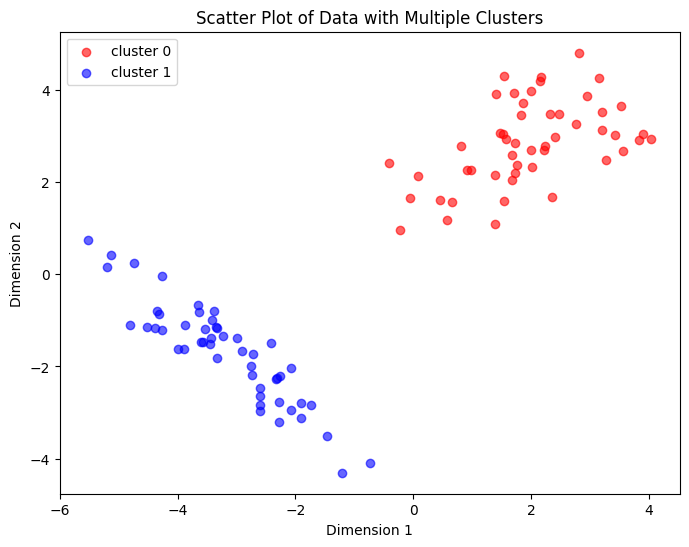

In [29]:
import torch
import matplotlib.pyplot as plt

# Parameters for two clusters
means = [torch.tensor([2.0, 3.0]), torch.tensor([-3.0, -2.0])]  # List of mean vectors
covariances = [
    torch.tensor([[1.0, 0.5], [0.5, 1.0]]),  # Covariance matrix for cluster 1
    torch.tensor([[1.0, -0.9], [-0.9, 1.0]])  # Covariance matrix for cluster 2
]
num_samples_per_cluster = 50  # Samples per cluster

# Generate data for each cluster
labels=[]
data = []
for ind, (mean, cov) in enumerate(zip(means, covariances)):
    z = torch.randn(num_samples_per_cluster, len(mean))  # Standard normal samples
    L = torch.linalg.cholesky(cov)  # Cholesky decomposition of covariance matrix
    cluster_data = z @ L.T + mean  # Transform to desired mean and covariance
    data.append(cluster_data)
    labels.append(torch.ones(num_samples_per_cluster)*ind)

#print(len(data[0]))
# Combine all cluster data
data = torch.cat(data, dim=0)
labels = torch.cat(labels, dim=0)

print(data)
print(labels.shape)


# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0][labels==0], data[:, 1][labels==0], c="r",label="cluster 0", alpha=0.6)
plt.scatter(data[:, 0][labels==1], data[:, 1][labels==1], c="b",label="cluster 1", alpha=0.6)
plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot of Data with Multiple Clusters')
plt.show()
